# KOH Posterior Analysis using Mici

This notebook looks at the different ways to implement an MCMC algorithm using Gaussian random-walk Metropolis proposal under the Mici framework.

The goal is to discover the best set-up and compare results against the MATLAB code previously implemented.

First, import the required packages and set up the KOH and Mici frameworks.

In [6]:
import matlabmodel as mm
from dataloader import DataLoader
from kohgpjax.mappings import mapRto01, map01toR, mapRto0inf, map0inftoR
from MATLAB_mappings import ell2rho, beta2ell
from jax import jit, grad

import numpy as np
import mici

import matplotlib.pyplot as plt

import arviz

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

In [7]:
seed = 1234
n_chain = 1
n_dim = 7
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    # map0inftoR(beta2ell(2)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])

param_transform_mici_to_gpjax = lambda x: [
    [ # theta (calibration) parameters
        mapRto01(x[0])
    ],
    [ # lengthscale parameters
        mapRto0inf(x[1]), 
        mapRto0inf(x[2]), 
    ],
    [ # lambda (variance) parameters
        mapRto0inf(x[3]), 
        mapRto0inf(x[4]), 
        mapRto0inf(x[5]), 
        mapRto0inf(x[6])
    ]
]

tmax = 0.6
tmin = 0.2


##### KOH Model #####
dataloader = DataLoader('data/simple_field.csv', 'data/simple_comp.csv')
data = dataloader.get_data() # loads normalised/standardised data
model = mm.MatlabModel(*data)
jitted_neg_log_posterior_density = jit(
    model.get_KOH_neg_log_pos_dens_func(
        param_transform_mici_to_gpjax
    )
)
grad_neg_log_posterior_density = jit(
    grad(
        model.get_KOH_neg_log_pos_dens_func(
            param_transform_mici_to_gpjax
        )
    )
)

def neg_log_pos_dens(x):
    return np.asarray(jitted_neg_log_posterior_density(x))

def grad_neg_log_pos_dens(x):
    return np.asarray(grad_neg_log_posterior_density(x))

##### Mici #####
# system = mici.systems.EuclideanMetricSystem(
#     neg_log_dens=jitted_neg_log_posterior_density,
#     grad_neg_log_dens=grad_neg_log_posterior_density,
# )
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=neg_log_pos_dens,
    grad_neg_log_dens=grad_neg_log_pos_dens,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

## Setup 1

Adapters:
- DualAveragingStepSizeAdapter(0.234)
- OnlineCovarianceMetricAdapter()

Results:
- Fails to achieve the target acceptance rate of 0.234, instead achieves around 0.2
- ESS bulk values are very similar for each variable.
- Parameter estimate for $\theta$ is very good. 
- 

In [8]:
##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.8),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

def trace_func(state):
    return {
        'theta': state.pos[0], 
        'ell_eta_1': state.pos[1], 
        'ell_eta_2': state.pos[2],
        'lambda_eta': state.pos[3],
        'lambda_delta': state.pos[4],
        'lambda_epsilon': state.pos[5],
        'lambda_epsilon_eta': state.pos[6],
    }

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, 
    n_main_iter, 
    init_states, 
    adapters=adapters, 
    n_process=n_chain, # only 1 works on MacOS
    trace_funcs=[trace_func]
)

Sampling stage: Initial fast adaptive [00:02] > Slow adaptive (1/7) [00:00] > Slow adaptive (2/7) [00:00] > Slow adaptive (3/7) [00:01] > Slow adaptive (4/7) [00:02] > Slow adaptive (5/7) [00:05] > Slow adaptive (6/7) [00:10] > Slow adaptive (7/7) [00:31] > Final fast adaptive [00:00] > Main non-adaptive [02:18]

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Chain 1/1: 100%|██████████|10000/10000 [02:18<00:00, 72.05it/s, accept_stat=0.926]

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/mici/systems.py:189: RuntimeWarning: invalid value encountered in add
  return self.h1(state) + self.h2(state)


In [10]:
arviz.summary(traces)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.258,0.133,-0.499,-0.003,0.004,0.003,922.0,1354.0,NaN
ell_eta_1,-2.334,0.033,-2.397,-2.274,0.001,0.001,1106.0,2019.0,NaN
ell_eta_2,-0.953,0.057,-1.062,-0.847,0.002,0.001,1172.0,1972.0,NaN
lambda_eta,-1.352,0.212,-1.762,-0.969,0.007,0.005,974.0,2182.0,NaN
lambda_delta,3.510,0.284,2.923,4.006,0.009,0.007,934.0,1563.0,NaN
lambda_epsilon,9.047,0.347,8.418,9.703,0.011,0.008,1066.0,1741.0,NaN
lambda_epsilon_eta,11.260,0.111,11.046,11.465,0.003,0.002,1089.0,2192.0,NaN


In [11]:
for var, trace in traces.items():
    print(var, ": ", np.mean(trace[0]), '±', np.std(trace[0]))

theta :  -0.25825260752176593 ± 0.13253060992595658
ell_eta_1 :  -2.33425817843883 ± 0.03269290876246612
ell_eta_2 :  -0.9532837774781853 ± 0.05683063040184725
lambda_eta :  -1.3516633012498027 ± 0.21237392308554395
lambda_delta :  3.5098652374241617 ± 0.2844713570226948
lambda_epsilon :  9.046553565368557 ± 0.3470896807592701
lambda_epsilon_eta :  11.260413549116947 ± 0.1111340213015211


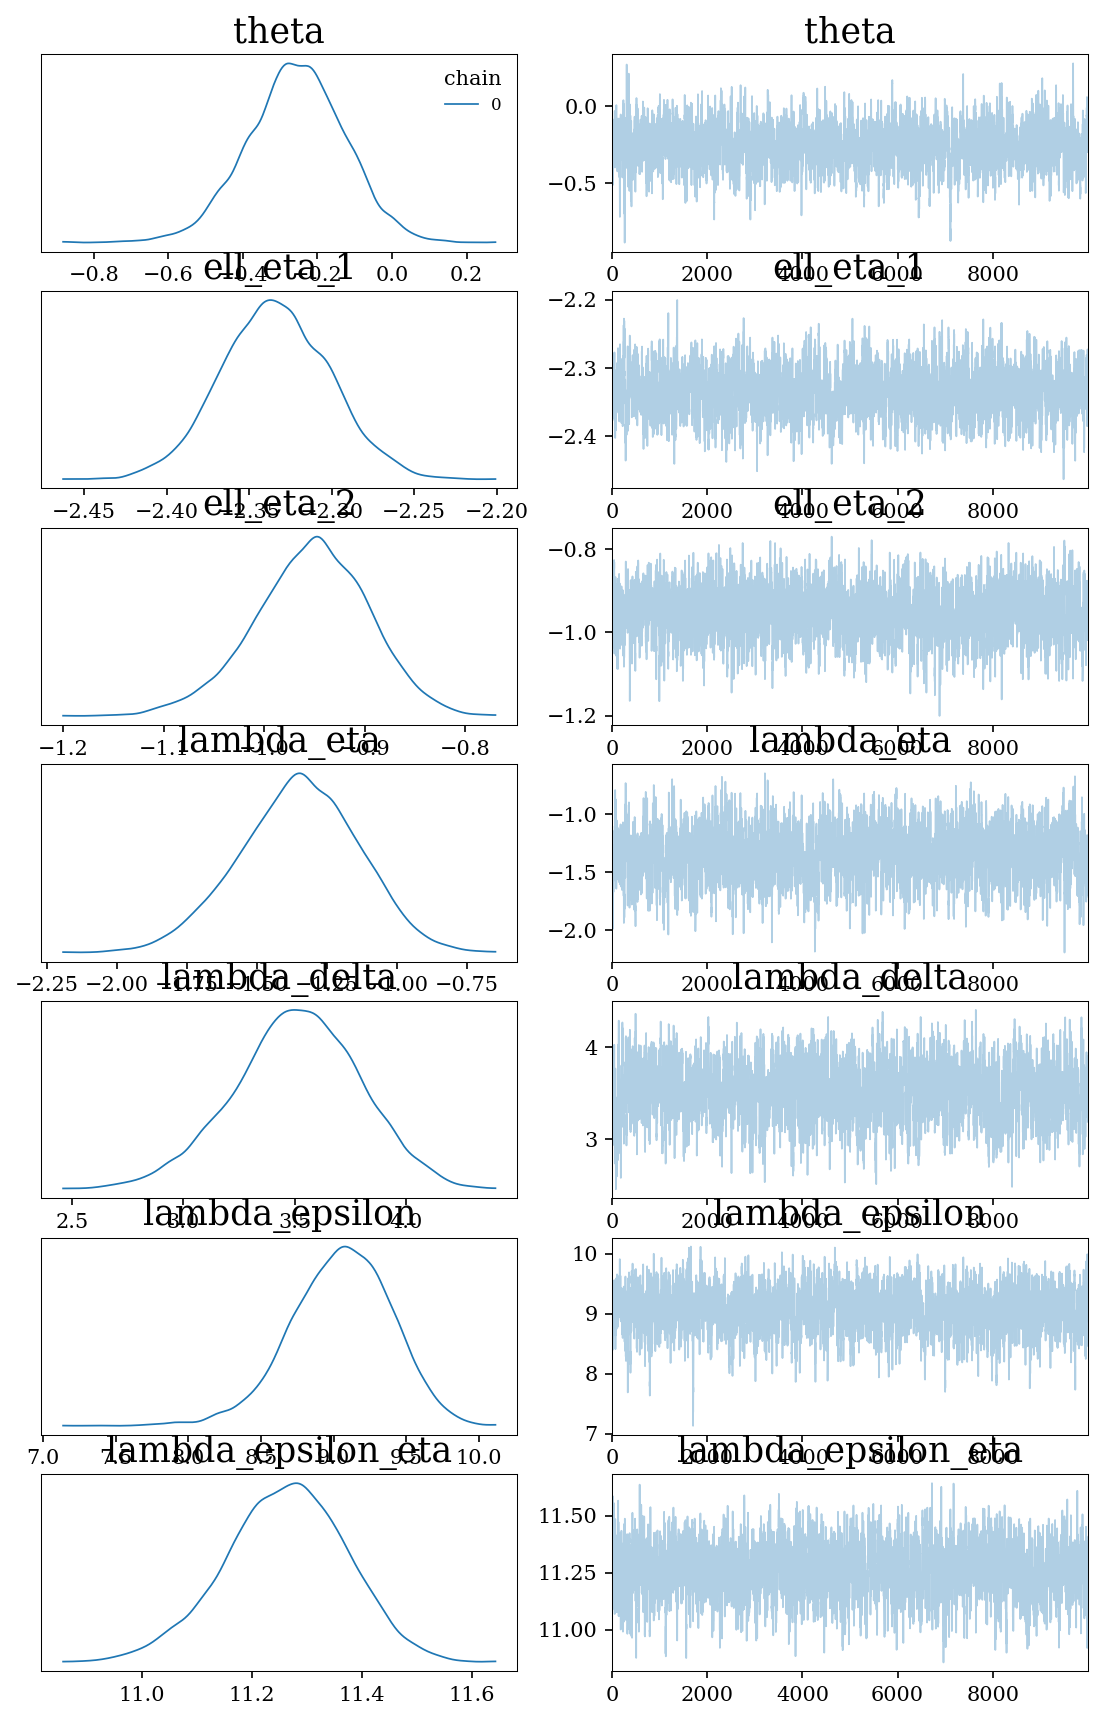

In [12]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )


# Transform the Chains

In [13]:
traces_transformed = {}
for var, trace in traces.items():
    if var == 'theta':
        traces_transformed[var] = mapRto01(trace[0])*(tmax-tmin) + tmin
    elif var == 'ell_eta_1' or var == 'ell_eta_2':
        traces_transformed[var] = ell2rho(mapRto0inf(trace[0]))
    else:
        traces_transformed[var] = mapRto0inf(trace[0])

for var, trace in traces_transformed.items():
    print(var, ": ", np.mean(trace), '±', np.std(trace))

theta :  0.4255696590445648 ± 0.012955591036650156
ell_eta_1 :  2.30217184299604e-06 ± 2.236520593200379e-06
ell_eta_2 :  0.43082655820621724 ± 0.041079707882922145
lambda_eta :  0.264657542159825 ± 0.056028403365991915
lambda_delta :  34.802351063649986 ± 9.850815508012504
lambda_epsilon :  8995.1624001038 ± 3035.541127855364
lambda_epsilon_eta :  78163.09146782468 ± 8636.866757304604


In [14]:
arviz.summary(traces_transformed)

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.426,0.013,0.401,0.450,0.000,0.000,922.0,1363.0,NaN
ell_eta_1,0.000,0.000,0.000,0.000,0.000,0.000,1106.0,2019.0,NaN
ell_eta_2,0.431,0.041,0.351,0.506,0.001,0.001,1172.0,1972.0,NaN
lambda_eta,0.265,0.056,0.166,0.371,0.002,0.001,974.0,2182.0,NaN
lambda_delta,34.802,9.851,16.817,52.545,0.312,0.220,934.0,1563.0,NaN
lambda_epsilon,8995.162,3035.693,3593.205,14653.019,88.744,62.767,1066.0,1741.0,NaN
lambda_epsilon_eta,78163.091,8637.299,61952.485,94226.436,260.614,184.331,1089.0,2192.0,NaN


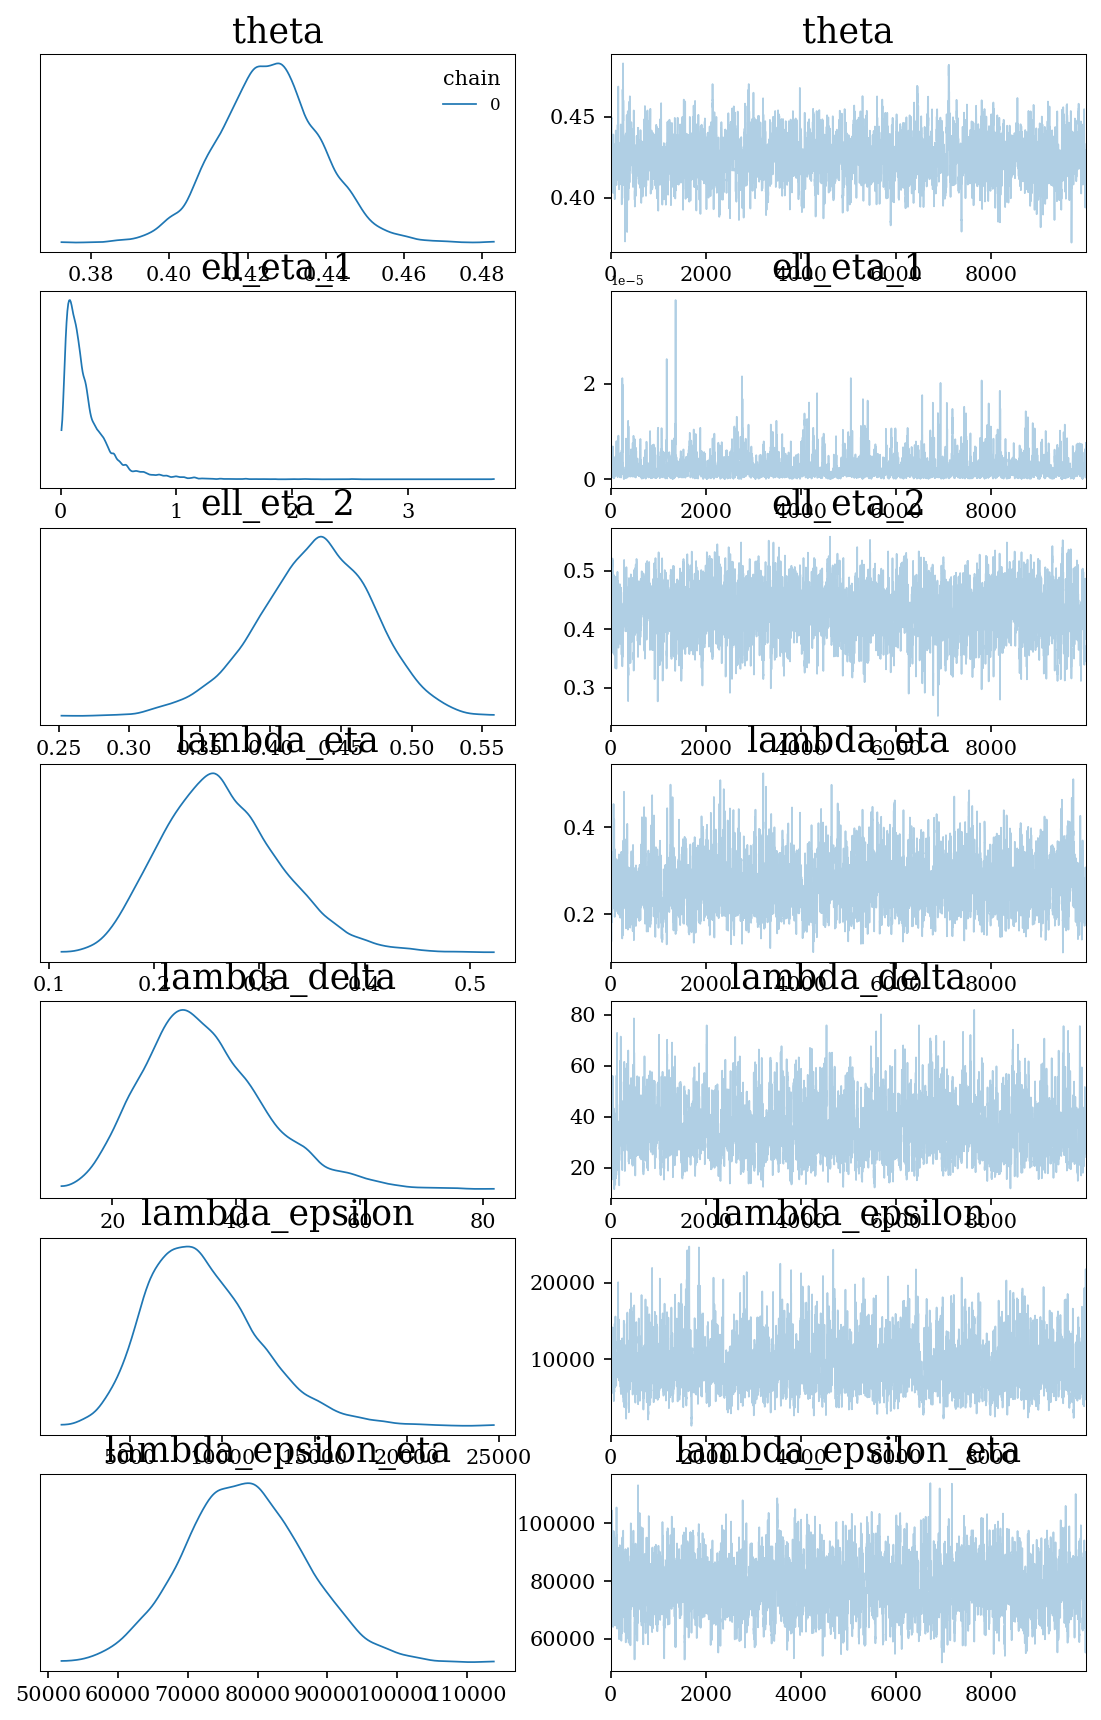

In [15]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces_transformed,
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
plt.show()